<a href="https://colab.research.google.com/github/OthmaneAbder2303/Practical-Deep-Learning/blob/main/non-linear%20topology/age_gender_functional_api.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
from google.colab import userdata
import os

os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')

!kaggle datasets download -d jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
utkface-new.zip: Skipping, found more recently modified local copy (use --force to force download)


In [31]:
import zipfile
zip = zipfile.ZipFile("utkface-new.zip",'r')
zip.extractall("/sample_data/")
zip.close()

In [32]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [33]:
folder_path = '/sample_data/utkface_aligned_cropped/UTKFace'

In [34]:
age=[]
gender=[]
img_path=[]
for file in os.listdir(folder_path):
  age.append(int(file.split('_')[0]))
  gender.append(int(file.split('_')[1]))
  img_path.append(file)

In [35]:
len(age)

23708

In [36]:
df = pd.DataFrame({'age':age,'gender':gender,'img':img_path})

In [37]:
df.shape

(23708, 3)

In [38]:
df.head()

,age,gender,img
0,2,1,2_1_4_20161221195838329.jpg.chip.jpg
1,54,1,54_1_0_20170117191523029.jpg.chip.jpg
2,14,0,14_0_1_20170113145153262.jpg.chip.jpg
3,24,1,24_1_2_20170116170616076.jpg.chip.jpg
4,90,0,90_0_0_20170111210753614.jpg.chip.jpg


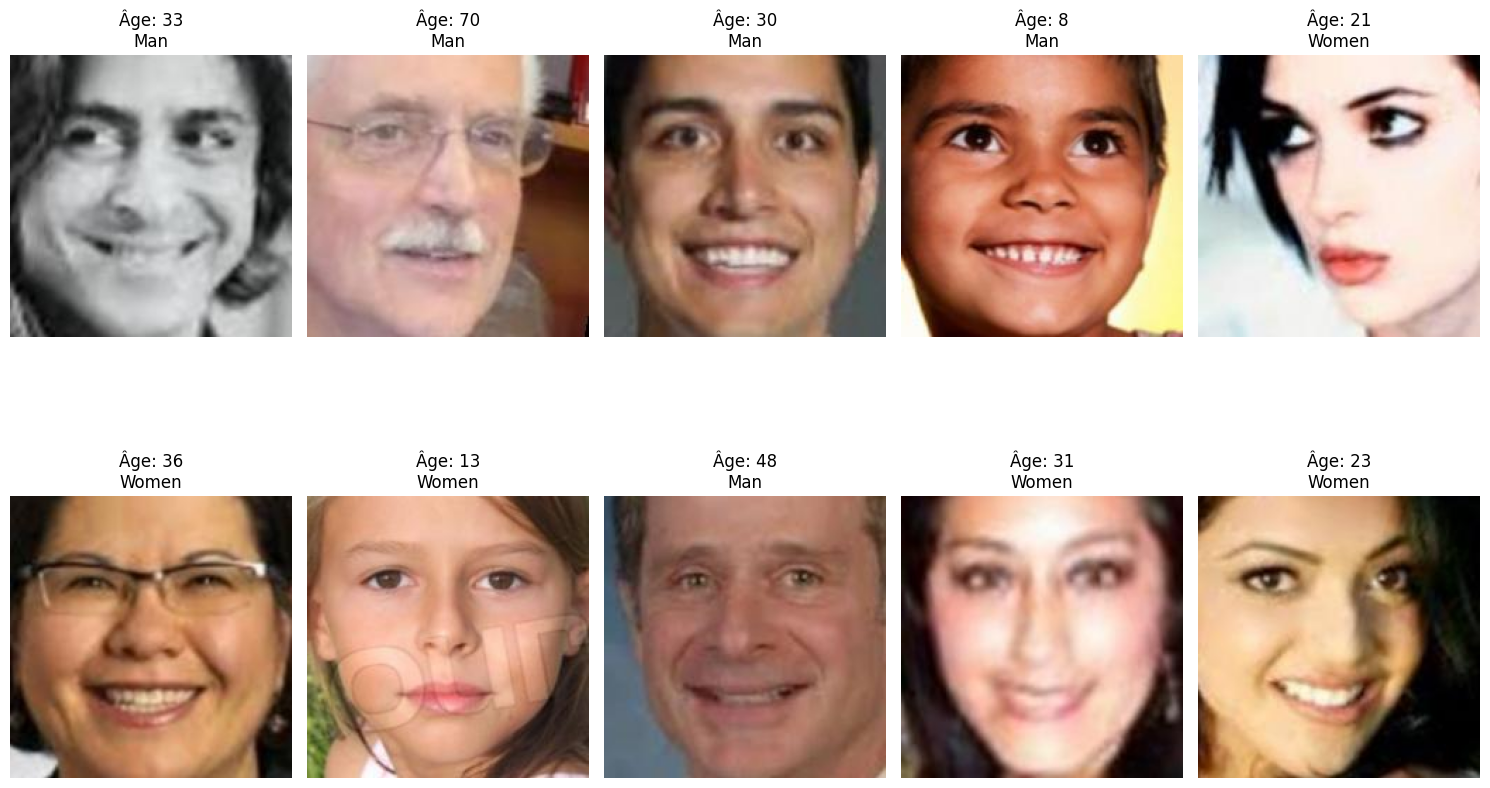

In [39]:
import cv2
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

sample_df = df.sample(10)

for i, (index, row) in enumerate(sample_df.iterrows()):
    plt.subplot(2, 5, i + 1)

    img_full_path = os.path.join(folder_path, row['img'])
    image = cv2.imread(img_full_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    gender_label = "Man" if row['gender'] == 0 else "Women"

    plt.imshow(image)
    plt.title(f"Age: {row['age']}\n{gender_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [40]:
train_df = df.sample(frac=1,random_state=0).iloc[:20000]
test_df = df.sample(frac=1,random_state=0).iloc[20000:]

In [41]:
train_df.shape

(20000, 3)

In [42]:
test_df.shape

(3708, 3)

In [43]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [44]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=folder_path,
    x_col='img',
    y_col=['age', 'gender'],
    target_size=(200, 200),
    batch_size=32,
    class_mode='raw'
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory=folder_path,
    x_col='img',
    y_col=['age','gender'],
    target_size=(200,200),
    class_mode='raw'
)

Found 20000 validated image filenames.
Found 3708 validated image filenames.


In [45]:
def final_multi_output_wrapper(gen):
    for x, y in gen:
        yield x, {
            'age': y[:, 0].astype('float32'),
            'gender': y[:, 1].astype('float32')
        }

train_gen_final = final_multi_output_wrapper(train_generator)
test_gen_final = final_multi_output_wrapper(test_generator)

In [46]:
from keras.applications.resnet50 import ResNet50
from keras.layers import *
from keras.models import Model

In [47]:
resnet = ResNet50(include_top=False, input_shape=(200,200,3))

In [48]:
resnet = ResNet50(include_top=False, input_shape=(200,200,3))

#resnet.trainable = False
resnet.trainable = True
for layer in resnet.layers[:-30]:
    layer.trainable = False

output = resnet.layers[-1].output

#flatten = Flatten()(output)
gap = GlobalAveragePooling2D()(resnet.output)

dense1 = Dense(256, activation='relu')(gap)
drop1 = Dropout(0.3)(dense1)
output1 = Dense(1, activation='linear', name='age')(drop1)

# dense1 = Dense(512, activation='relu')(flatten)
# dense2 = Dense(512,activation='relu')(flatten)

dense2 = Dense(256, activation='relu')(gap)
drop2 = Dropout(0.3)(dense2)
output2 = Dense(1, activation='sigmoid', name='gender')(drop2)

# dense3 = Dense(512,activation='relu')(dense1)
# dense4 = Dense(512,activation='relu')(dense2)

# output1 = Dense(1,activation='linear',name='age')(dense3)
# output2 = Dense(1,activation='sigmoid',name='gender')(dense4)

In [49]:
model = Model(inputs=resnet.input,outputs=[output1,output2])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 206, 206,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 100, 100,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 100, 100,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 100, 100,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 102, 102,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 50, 50,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 50, 50,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 50, 50,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 50, 50,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 50, 50,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 50, 50,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 50, 50,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 50, 50,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 50, 50,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 50, 50,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 50, 50,    │      1,024 │ conv2_block1_3_c

 Total params: 24,637,314 (93.98 MB)

 Trainable params: 15,499,778 (59.13 MB)

 Non-trainable params: 9,137,536 (34.86 MB)

In [50]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss={
        'age': 'mae',
        'gender': 'binary_crossentropy'
    },
    metrics={
        'age': 'mae',
        'gender': 'accuracy'
    },
    loss_weights={
        'age':1.0,
        'gender':10.0
    }
)

In [51]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

history = model.fit(
    train_gen_final,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=test_gen_final,
    validation_steps=len(test_generator),
    callbacks=callbacks
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 250s 366ms/step - age_loss: 20.7522 - age_mae: 20.7522 - gender_accuracy: 0.5598 - gender_loss: 0.6802 - loss: 27.5544 - val_age_loss: 13.4006 - val_age_mae: 13.4033 - val_gender_accuracy: 0.6451 - val_gender_loss: 0.6220 - val_loss: 19.6245 - learning_rate: 1.0000e-05
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 214s 342ms/step - age_loss: 13.6326 - age_mae: 13.6326 - gender_accuracy: 0.6738 - gender_loss: 0.6051 - loss: 19.6838 - val_age_loss: 12.2358 - val_age_mae: 12.2358 - val_gender_accuracy: 0.6891 - val_gender_loss: 0.5760 - val_loss: 17.9961 - learning_rate: 1.0000e-05
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 213s 341ms/step - age_loss: 13.0094 - age_mae: 13.0094 - gender_accuracy: 0.6729 - gender_loss: 0.6034 - loss: 19.0438 - val_age_loss: 12.9701 - val_age_mae: 12.9701 - val_gender_accuracy: 0.7144 - val_gender_loss: 0.5597 - val_loss: 18.5669 - learning_rate: 1.0000e-05
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 211s 338ms/step - age_loss: 12

In [54]:
model.save('model_age_gender_v2.keras')

print("Success !")

Success !


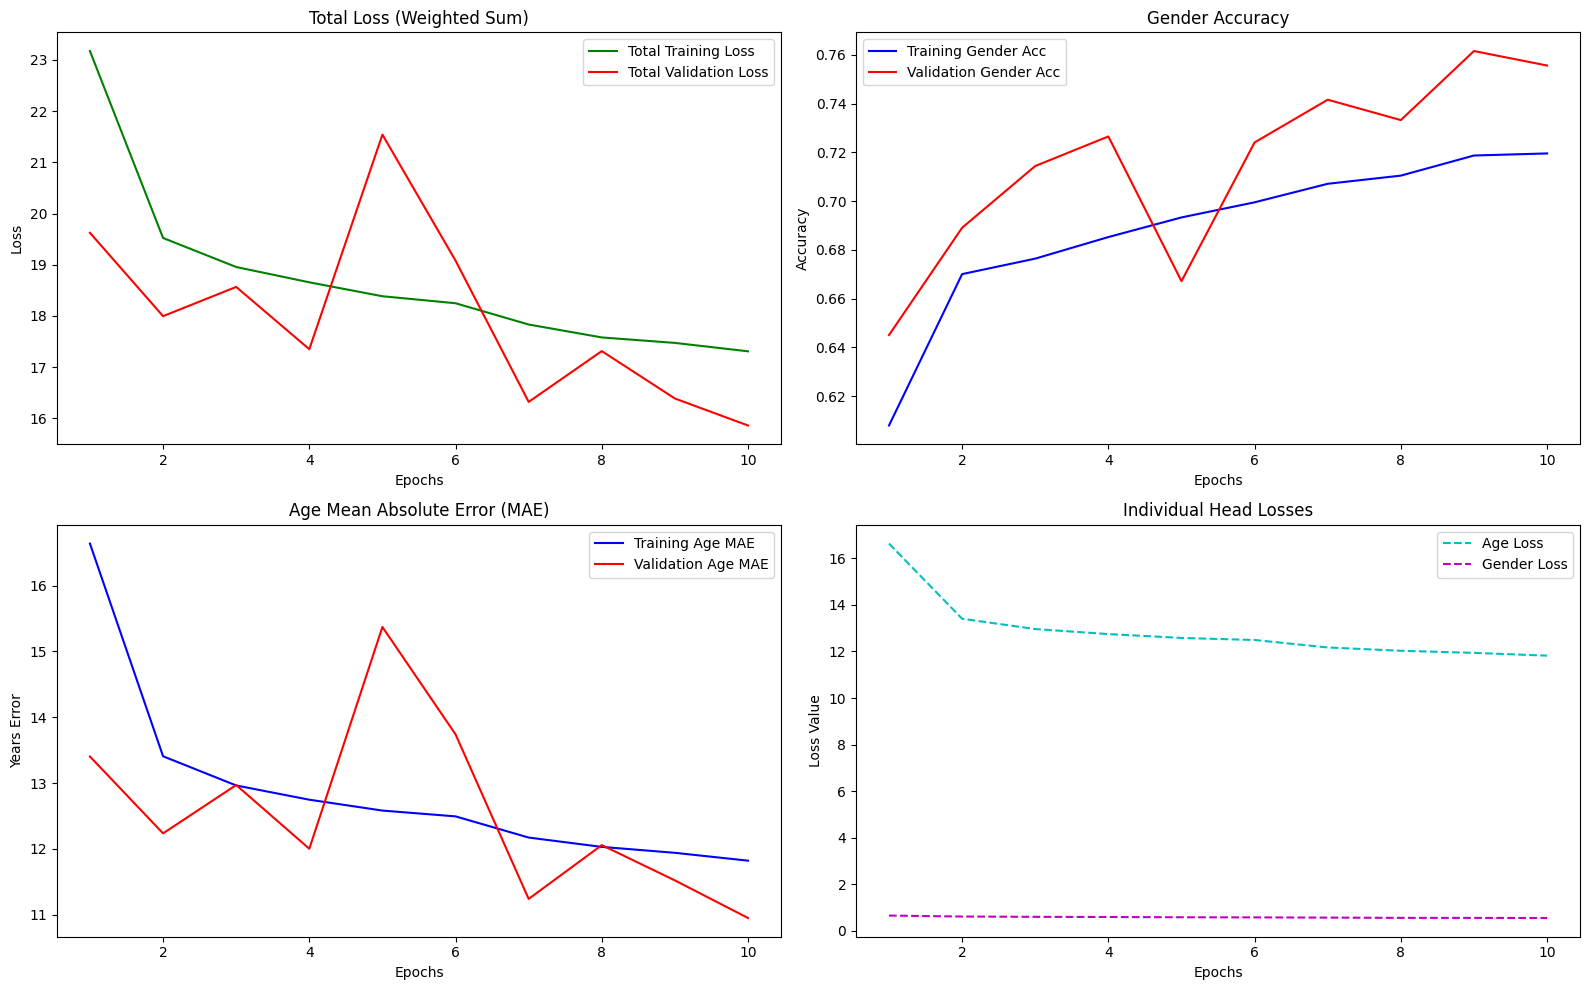

In [58]:
import matplotlib.pyplot as plt

def plot_full_history(history):
    # Retrieve data from the history object
    epochs = range(1, len(history.history['loss']) + 1)

    plt.figure(figsize=(16, 10))

    # 1. Overall Loss (Total)
    plt.subplot(2, 2, 1)
    plt.plot(epochs, history.history['loss'], 'g-', label='Total Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'r-', label='Total Validation Loss')
    plt.title('Total Loss (Weighted Sum)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 2. Gender Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, history.history['gender_accuracy'], 'b-', label='Training Gender Acc')
    plt.plot(epochs, history.history['val_gender_accuracy'], 'r-', label='Validation Gender Acc')
    plt.title('Gender Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # 3. Age Error (MAE)
    plt.subplot(2, 2, 3)
    plt.plot(epochs, history.history['age_mae'], 'b-', label='Training Age MAE')
    plt.plot(epochs, history.history['val_age_mae'], 'r-', label='Validation Age MAE')
    plt.title('Age Mean Absolute Error (MAE)')
    plt.xlabel('Epochs')
    plt.ylabel('Years Error')
    plt.legend()

    # 4. Individual Losses (Age vs. Gender)
    # Crucial to see if one output is dominating the gradient
    plt.subplot(2, 2, 4)
    plt.plot(epochs, history.history['age_loss'], 'c--', label='Age Loss')
    plt.plot(epochs, history.history['gender_loss'], 'm--', label='Gender Loss')
    plt.title('Individual Head Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss Value')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function
plot_full_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


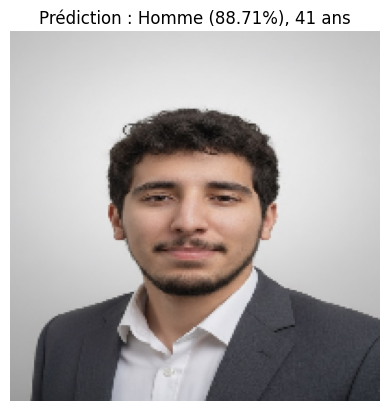

In [57]:
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_age_gender(img_path, model):
    img = image.load_img(img_path, target_size=(200, 200))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    pred = model.predict(img_array)

    predicted_age = int(np.round(pred[0][0][0]))
    predicted_gender = "Man" if pred[1][0][0] < 0.5 else "Women"
    confidence = (1 - pred[1][0][0]) if pred[1][0][0] < 0.5 else pred[1][0][0]

    plt.imshow(img)
    plt.title(f"Prediction : {predicted_gender} ({confidence:.2%}), {predicted_age} years")
    plt.axis('off')
    plt.show()

predict_age_gender('/content/pdp pro oa.JPG', model)